**Viscek Model**


> Viscek Model is a collective motion model which works based on the following assumptions:
1.  Individuals have constant absolute velocity
2.  At each time step, individuals assume the average velocity of the neighbors + random perturbation (noise)


> So, if:
*   N is the number of individuals
*   xᵢ(t) is the position vector of the individual i
*   𝛳 is the angle of the individuals
*   Δt is one time step
*   v0  is the speed of every individual
*   D is the length/width of the boundary
*   r is the interaction radius
*   Δ𝛳 is the random uniform noise, the Viscek model is as follows:
*   vₐ is the average normalized velocity 



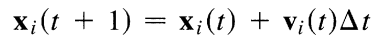

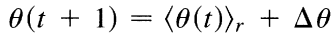

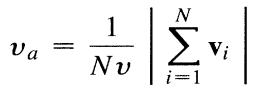

Based on these equations, let us construct the Viscek model!

Firstly, let us install and import all the packages we shall be necessarily using for this code.



















In [ ]:
%pip install git+https://github.com/tee-lab/PyDaddy.git
import pydaddy
import numpy; #package for numerical (matrix) calculations
import matplotlib.pyplot as plt; #this gives us access to plotting functions
from matplotlib.animation import FuncAnimation # Used to animate the movement of the boids

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tee-lab/PyDaddy.git to /tmp/pip-req-build-qlu8duzi
  Running command git clone -q https://github.com/tee-lab/PyDaddy.git /tmp/pip-req-build-qlu8duzi
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.6 MB 9.3 MB/s 
  Created wheel for pydaddy: filename=pydaddy-1.0.0-py3-none-any.whl size=20354306 sha256=2cf609986ca153703303ccfe0cfc16ea788c69804e9cbc81cfc162f36c18f5ec
  Stored in directory: /tmp/pip-ephem-wheel-cache-tmg8_flh/wheels/38/59/e7/4f940a5687bed6aabbf75913a2238aed5fe65411fe9e25212c
  Created wheel for sdeint: filename=sdeint-0.3.0-py3-none-any.whl size=25907 sha256=26be5dac6cb440f2d85947e81cd26f9fee9125f86c97278c52ca687726931fb1
  Stored in directory: /root/.cache/pip/wheels/64/30/eb/70e285284253db9252d1dcdc6cea14cc860d95e7ed201efd9d
Su

Each individual is associated with two continuosly changing (with time) variables: position and angle. Therefore, to store these values we need vectors. To do so, we write a function to initialize the vectors to store these values and assign them a random initial state. The function below creates the vectors and assigns them random initial values and returns these initial state vectors.

In [ ]:
def initializeBoids(N, circle_R):                                   # Function to give initial random positional values to the N number of boids
    boid_r_state0 = numpy.zeros(shape=(N))
    boid_pos_angle_state0 = numpy.zeros(shape=(N))
    boid_v_angle_state0 = numpy.zeros( shape=(N))                # We created an angle array of size N and assigned all angles to 0 initially
    boid_pos_state0 = numpy.zeros( shape=(2,N))
    boid_r_state0 = numpy.random.uniform(0,circle_R,N)
    boid_pos_angle_state0 = numpy.random.uniform(-numpy.pi,numpy.pi,N)                   
    boid_v_angle_state0 =  numpy.random.uniform(-numpy.pi,numpy.pi,N)    # Here we assign the direction of velocity to all the boids (from -pi to pi)
    boid_pos_state0[0,:] = boid_r_state0 * numpy.cos(boid_pos_angle_state0)           # Using r and theta, we are calculating position in x and y terms
    boid_pos_state0[1,:] = boid_r_state0 * numpy.sin(boid_pos_angle_state0)
    return  boid_v_angle_state0, boid_pos_state0;

To visualize how the individuals would look like in an enclosement, we plot them (their positions and angles within the boundary). 

In [ ]:
def plotBoids(angle, pos, circle_R, N):                          # Function to plot the boids on a 2D plane (its enclosure)
    fig, axes = plt.subplots()
    axes.set_xlim(-circle_R,circle_R)                                            # Setting the limit of x and y axes therefore assigning a size to the enclosure
    axes.set_ylim(-circle_R,circle_R)
    Scale = circle_R/200                                   
    Enclosure = plt.Circle( (0, 0 ),	circle_R , fill= False)
    axes.set_aspect( 1 )
    axes.add_artist( Enclosure )
    plt.title( 'Circle' )
    for n in range(N):
        xpos, ypos = pos[0,n], pos[1,n]
        plt.arrow( xpos, ypos, 5*Scale*numpy.cos(angle[n]), 5*Scale*numpy.sin(angle[n]), head_width=2*Scale, head_length=Scale, fc='green', ec='green') # plotting an arrow to depict the boids, alternative: Use a quiver plot

    plt.show()                                                   # This plots the boids on said enclosure
    return fig

Another variable in this system would be the velocity of the individuals which constantly varies in directly but remains constant in magnitude. Therefore, to keep track of velocity of inidividuals, we initialize a vector and store the x and y components of the velocity of all individuals:

In [ ]:
def calcVel(N,v0, angle):
  v_vec = numpy.zeros(shape=(2,N))
  for n in range(N):
    theta= angle[n]
    v_vec[0,n]= v0*numpy.cos(theta)
    v_vec[1,n]= v0*numpy.sin(theta)
  return(v_vec)

Since each individuals velocity is influenced by its neighbors, we must determine these neighbors for every individuals. To do so, we use the following function, which determines the individuals within a certain radius of an individual by examining the distance between individuals.

In [ ]:
x = numpy.zeros( shape=(2,10))  
x

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
def neighborCal(present_angle, present_pos, neighborMeanAngles, N, R, circle_R):
    for i in range (N):
        neighborAngle=[]
        for j in range (N):
            i_pos = present_pos[:,i]
            j_pos = present_pos[:,j]
            dist_x = i_pos[0] - j_pos[0]
            dist_y = i_pos[1] - j_pos[1]
            dist = numpy.sqrt(numpy.square(dist_x)+numpy.square(dist_y)) 
            if (dist < R):
              neighborAngle.append(present_angle[j])
        neighborMeanAngles[i] =  numpy.arctan2(numpy.mean(numpy.sin(neighborAngle)), numpy.mean(numpy.cos(neighborAngle)))
    return (neighborMeanAngles)

This model is of the form:
future (state) = f (current (state)). Threfore, the determine the next state of each individual we neet to input their current states. The calculations to get the next state, in tune with the model equations are done below:

In [ ]:
def state_update(present_angle, present_pos, time_step, eta, R, circle_R, v0, N):      # Function to update the state of boids according to the Viscek model
    next_angle = numpy.zeros(N)                                   # first set the next state to the current state of the boids
    next_pos = numpy.zeros(shape=(2,N))
    neighborMeanAngles = numpy.zeros(N)
    next_v = numpy.zeros(shape=(2,N))
    

    for n in range(N):      # Here, we update the boid positions one by one
        v_x = v0*numpy.cos(present_angle[n])
        v_y = v0*numpy.sin(present_angle[n])                               # Current velocity values
        next_pos[ 0,n ] = present_pos[ 0,n ] + time_step*v_x       # x1 = x0 + delta_t * v (updating the position)
        next_pos[ 1,n ] = present_pos[ 1,n ] + time_step*v_y  
        r_x_1_y_1 = numpy.sqrt(numpy.square(next_pos[0,n])+numpy.square(next_pos[1,n])) # Calculating distance of the next position from the centre
        if (r_x_1_y_1 >= circle_R):                            # Introducing reflective boundary
           x_0 = present_pos[0,n]
           y_0 = present_pos[1,n]
           x_1 = next_pos[0,n]
           y_1 = next_pos[1,n]
           a = numpy.square(v0 * time_step)
           b = 2 * (y_1 - y_0) * ((y_1 - y_0)*x_0 + (x_1 - x_0)*y_0)
           c = (x_0*(y_1 - y_0)*((y_1 - y_0)*x_0 - 2*(x_1 - x_0)*y_0)) - (numpy.square(x_1 - x_0) * numpy.square(circle_R))
           rootof_b2_4ac = numpy.sqrt((numpy.square(b))-(4*a*c))
           x_2_a = ((-1*b) + rootof_b2_4ac)/(2*a)
           y_2_a = numpy.sqrt(numpy.square(circle_R) - numpy.square(x_2_a))
           eqn_a = (x_1 - x_0)*y_2_a - (y_1 - y_0)*(x_2_a - x_0) - y_0
           if (eqn_a != 0):
               y_2_a = -1 * y_2_a
           x_2_b = ((-1*b) - rootof_b2_4ac)/(2*a)
           y_2_b = numpy.sqrt(numpy.square(circle_R) - numpy.square(x_2_b))
           eqn_b = (x_1 - x_0)*y_2_b - (y_1 - y_0)*(x_2_b - x_0) - y_0
           if (eqn_b != 0):
               y_2_b = -1 * y_2_b
           elif (y_2_b == y_2_a):
               y_2_b = -1 * y_2_b
           x_2 = 0
           y_2 = 0
           if (numpy.sqrt(numpy.square(x_1 - x_2_a)+numpy.square(y_1 - y_2_a)) <= numpy.sqrt(numpy.square(x_1 - x_2_b)+numpy.square(y_1 - y_2_b))):
             x_2 = x_2_a
             y_2 = y_2_a
           else:
             x_2 = x_2_b
             y_2 = y_2_b
           x_3 = x_2 - ((y_2 * (y_1*x_2 - y_2*x_1))/numpy.square(circle_R))
           y_3 = ((x_2*(y_1*x_2 - y_2*x_1))/numpy.square(circle_R)) + y_2
           next_pos[0,n] = (2*x_3) - x_1
           next_pos[1,n] = (2*y_3) - y_1
           present_angle[n] = numpy.arctan2((next_pos[1,n] - y_2),(next_pos[0,n] - x_2))


    neighborMeanAngles = neighborCal(present_angle, present_pos, neighborMeanAngles, N, R, circle_R)
    #noise = (numpy.random.rand(N) - 0.5) * eta
    noise = numpy.zeros(shape=(N))
    for n in range(N):
      noise[n]=numpy.random.uniform(-eta/2,eta/2)

    next_angle = numpy.add(neighborMeanAngles, noise) # Updating the angular data of the boid by assigning neighbor average angle and adding noise
    next_v[:,:]= calcVel(N,v0, next_angle)
   # for n in range(N):
    #  theta = next_angle[n]
     # v_vector[numpy.array([0,1]) + 2*n] = v0*numpy.array([numpy.cos(theta),numpy.sin(theta)])                                                           # Calculating the next velocity vector of individual n and storing it
    return(next_angle, next_pos, next_v)

The following function plots the trajectory of all individuals during the time period:

In [ ]:
def plottrajectories(trajectory_angles, trajectory_pos, circle_R):        # This plots the trajectory of the boids (i.e., the path followed by each boids during the duration of the simulation)
    fig, axes = plt.subplots()
    axes.set_xlim(-circle_R,circle_R)                                            # Setting the limit of x and y axes therefore assigning a size to the enclosure
    axes.set_ylim(-circle_R,circle_R)                                  
    Enclosure = plt.Circle( (0, 0 ),	circle_R , fill= False)
    axes.set_aspect( 1 )
    axes.add_artist( Enclosure )
    plt.title( 'Circle' )
    plt.plot( trajectory_pos[0,:,:].T, trajectory_pos[1,:,:].T ,'.')  # Plottng the trajectories {Plotting the co-ordinates of each boid over time by transposing the matrix to acess the coordinates of each boid over time (without transposing, you would get the coordinates of all boids in one time frame instead)}
    plt.show()

The following function is responsible for plotting various plots to show the boid movement information according to the viscek model. Initial and final state of boids, trajectory of boids, change in average velocity over time and change in order parameter over time are displayed:

In [ ]:
def plotCall(trajectory_angles, trajectory_pos, Order_param, avg_vel, time, circle_R):
  #Plotting data
    plt.figure(0)
    plottrajectories(trajectory_angles, trajectory_pos,circle_R) # trajectory plot
    plt.figure(1)
    plotBoids(trajectory_angles[:,0], trajectory_pos[:,:,0], circle_R, N) # initial state of boids
    plt.figure(2)
    plotBoids(trajectory_angles[:,-1], trajectory_pos[:,:,-1], circle_R, N) #final state of boids 
    print(avg_vel)                                                # Displaying the order parameter over time
    plt.figure(3)
    plt.ylim(0,1)
    plt.scatter(time,avg_vel)                                     # Average velocity plot
    plt.plot(time,avg_vel)
    plt.xlabel("T")
    plt.ylabel("Order parameter (Avg vel)")
    plt.show
    plt.figure(4)                                                   
    plt.ylim(-1,1)
    plt.scatter(time,Order_param[0,:], c = 'red')                # Order parameter (along x and y) plot
    plt.scatter(time,Order_param[1,:], c = 'green')
    plt.plot(time,Order_param[0,:], c = 'red', label = 'M_x')
    plt.plot(time,Order_param[1,:], c = 'green', label = 'M_y')
    plt.legend(['M_x', 'M_y'])
    plt.xlabel("T")
    plt.ylabel("Order parameter (Avg vel)")
    plt.show

The following function is used to do data-driven analysis using pyDaddy:

In [ ]:
def pyDaddyCall (Order_param,time_step):

    ddsde = pydaddy.Characterize(Order_param, time_step)
    F1 = ddsde.fit('F1', order=3, threshold=0.01)
    print("F1 =",F1)
    F2 = ddsde.fit('F2', order=3, threshold=0.01)
    print("F2 =",F2)
    G11 = ddsde.fit('G11', order=3, threshold=0.01)
    print("G11 =",G11)
    G22 = ddsde.fit('G22', order=3, threshold=0.01)
    print("G22 =",G22)
    G12 = ddsde.fit('G12', order=3, threshold=0.01)
    print("G12 =",G12)
    G21 = ddsde.fit('G21', order=3, threshold=0.01)
    print("G21 =",G21)
    print("When tune = true i.e., when the program sets the treshold:")
    F1 = ddsde.fit('F1', order=3, tune=True)
    print("F1 =",F1)
    F2 = ddsde.fit('F2', order=3, tune=True)
    print("F2 =",F2)
    G11 = ddsde.fit('G11', order=3, tune=True)
    print("G11 =",G11)
    G22 = ddsde.fit('G22', order=3, tune=True)
    print("G22 =",G22)
    G12 = ddsde.fit('G12', order=3, tune=True)
    print("G12 =",G12)
    G21 = ddsde.fit('G21', order=3, tune=True)
    print("G21 =",G21)
    ddsde.drift()
    ddsde.diffusion()
    ddsde.cross_diffusion()
    ddsde.summary()
    ddsde.noise_diagnostics()

Now that we have all the major functions to make the viscek model, we need to conduct a trial with all the initial state values. To do so, we use the following function which takes in the initial values as an input to give us the output (plots, pyDaddy analysis, and position and angles of the boids during the duration of the trial):

In [ ]:
def trial(N, eta, T, R, circle_R, time_step, v0): # values listed here are 'defaults': they are used if we don't specify the appropriate constant

    angle_state0, pos_state0 = initializeBoids(N, circle_R)          # We create and initialize state 0 (t=0) positional and angular values of the boids
    trajectory_angles = numpy.zeros(shape=(N,T))                # Creating matrices to store positional and angular data of boids over time
    trajectory_pos = numpy.zeros( shape=(2,N, T));
    trajectory_angles[:,0] = angle_state0
    trajectory_pos[:,:,0] = pos_state0
    v_vector = numpy.zeros(shape=(2,N,T))                       # Matrix to store velocity data of boids over time
    v_vector[:,:,0]= calcVel(N,v0, angle_state0)
    time = numpy.arange(0,T,1) 
    for t in range(T-1):                                        # Looping to update matrices with position, angles and velocity data
        trajectory_angles[:,t+1], trajectory_pos[:,:,t+1], v_vector[:,:,t+1] = state_update( trajectory_angles[:,t], trajectory_pos[:,:,t], time_step, eta, R, circle_R, v0, N) # repeatedly calling state update to get data
    #Order parameter calculation below:
    avg_vel = numpy.zeros(T)    #Initialize an average velocity vector of size T that serves as a order parameter
    M_x = numpy.zeros(T)
    M_y = numpy.zeros(T)
    Order_param = numpy.zeros(shape=(2,T))
    for t in range(T):        # Looping T times to get average velocity for every time step
      avg_vel[t]= numpy.sqrt((numpy.square(numpy.sum(v_vector[0,:,t]))+numpy.square(numpy.sum(v_vector[1,:,t]))))/(N*v0)  # Avg vel = magnitude of (sum of velocity vectors)/ (Number of boids * magnitude of velocity)
      M_x[t] = numpy.sum(v_vector[0,:,t])/(N*v0)
      M_y[t] = numpy.sum(v_vector[1,:,t])/(N*v0)
      Order_param[0,t]=M_x[t]
      Order_param[1,t]=M_y[t]
      
    #print(Order_param)
    plotCall(trajectory_angles, trajectory_pos, Order_param, avg_vel, time, circle_R)    # Calling function to make the plots
    
    pyDaddyCall (Order_param,time_step)                                                  # Calling funtion to do the data-drive SDE analysis using pyDaddy

    return(trajectory_pos,trajectory_angles)

Now that everything is ready, we just need to call the trial function with input values. For that, we take input values from the user and call trial.

In [ ]:
# The next few lines of code is to collect parameter values (input) from the user
#Note: The spyder platform I use doesn't support collecting imput from users so if you face the same problem, just directly assign values to N and eta in the code.
N =int(input("Enter the number of boids you want in the enclosure: "))
eta = float(input("Enter the maximum noise in the system: "))
circle_R = float(input("Enter the radius of the circular enclosure R (in units):")) 
R = float(input("Enter the radius of interaction (in units):"))
v = float(input("Enter the speed of the boids (in units/sec):"))
T = 1000000   # This is the number of timesteps in the simulation
time_step = 1

traj_pos, traj_angles = trial(N, eta, T, R, circle_R, time_step, v) # Calling the trial function

Enter the number of boids you want in the enclosure: 50
Enter the maximum noise in the system: 0.5
Enter the size of the enclosure D (one side in units):5
Enter the radius of interaction (in units):1
Enter the speed of the boids (in units/sec):0.03


To observe the simulation of the boids moving in accordance to the Viscek model, we use the following function:

In [ ]:
#Note: The animation doesn't work on colab and has to be executed on spyder or other platforms

def Animate(t):               # Function to get the animation of boids moving over time
      if (t<T):              # Function will run till we reach timestep T
                         
        plt.cla()             # Clears the plot before displaying new positions of the boids
        plt.xlim(-circle_R,circle_R)                                            # Setting the limit of x and y axes therefore assigning a size to the enclosure
        plt.ylim(-circle_R,circle_R)
        plt.gca().set_aspect(1)                                    
        Enclosure = plt.Circle( (0, 0 ),	circle_R , fill= False)
        plt.gca().add_patch(Enclosure)
        Scale = circle_R/200 
        plt.quiver(traj_pos[0,:,t],traj_pos[1,:,t],5*Scale*numpy.cos(traj_angles[:, t]), 5*Scale*numpy.sin(traj_angles[:, t])) # Displaying the boids positions at time t
        

The following snippet of code is to call the animation function! This should result in a animation of boids moving.

In [ ]:
t=0 
plt.figure(5)
ani = FuncAnimation(plt.gcf(),Animate,interval=1, frames=T, repeat_delay=1000)    # Animation
ani.save('myanimation_N_20_eta_1.5_D_5_r_1_b_0_modified.gif', fps=45)
plt.show() 